# Phoenix Autocall

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [2]:
N = 100000
T = 3
steps = 6

Npaths = 10000
dt = T/steps

m = int(T/dt)
DW = np.sqrt(T/m)*np.random.randn(N, m)
W = np.zeros((N, m+1))
W[:, 1:] = np.cumsum(DW, axis = 1)

def mc_paths(S0 = 100, sigma = 0.3, r = 0.01):
    size = (Npaths, steps)
    t = np.linspace(0,T,m+1)
    X_bs = S0 * np.exp( (r-(sigma**2)/2)*t + sigma * W)
    return X_bs

path = mc_paths(100, 0.3)

$\mathrm{C}= 100 $ net invested capital

$\mathrm{c}= 5\% $ coupon

$\mathrm{T}= 3$ years maturity

$\mathrm{B}= 80 $ barrier

$\mathrm{BC}= 90 $ barrier coupon

$S_{0}= 100 $ Spot price of the underlying



In [3]:
BC, C, c, bc_coupon, barrier = 100, 100, 0.05, 90, 80

The payoff formula can be simplified by taking N to be the number of coupons received by the investor:

$$
N=\mathbb{1}_{S_{1}>B C}+\mathbb{1}_{S_{2}>B C} * \mathbb{1}_{S_{1}<S_{0}}+\ldots+\mathbb{1}_{S_{1}<S_{0}, S_{2}<S_{0}, S_{T-1}<S_{0}} * \mathbb{1}_{S_{T}>B C}
$$

\\


$$
\begin{aligned}
Y &=\mathbb{1}_{S_{T} \geq B} * \mathbb{1}_{\max _{1 \leq t \leq T}\left(S_{t}\right)<S_{0}} * C *(1+N * c)+\\
&+C *\left(N * c +1+\frac{S_{T}-S_{0}}{S_{0}}\right) * \mathbb{1}_{S_{T}<B} * \mathbb{1}_{ \max _{1 \leq t \leq T}\left(S_{t}\right)<S_{0} }+\\
&+\mathbb{1}_{ \max _{1 \leq t \leq T}\left(S_{t}\right)>S_{0} } * C *(1+N * c)
\end{aligned}
$$

In [4]:
def number_coupons(path):
    '''
      Compute the number of coupons
      Args:
          path : 
            path of the underlying
      Returns:
          The number of coupons acquired
    '''
    n, _ = path.shape
    S_0 = np.array([BC] * len(path[:, 0])) #barrière haute
    test = np.array([1]*n)
    count = np.array([0]*n)
    for S_i in np.array(path[:, 1:].T):
        count = count + ((S_i > bc_coupon) * test).astype(int)
        test = (test * (S_i<S_0)).astype(int)
    return(count)

def phoenix_price(path, r = 0.01):
    '''
      Compute the price of phoenix autocall
      Args:
          path :
            path of the underlying
          r:
            Risk-free interest rate
          T:
            Maturity
      Returns:
          The price of phoenix autocall with for earch trajectorie
    '''
    S_0 = np.array([BC] * len(path[:, 0])) #barrière haute
    S_T = np.array(path[:, -1])
    N = number_coupons(path)
    Y = (S_T >= barrier) * (np.amax(path[:,1:], axis = 1) < S_0) * C * ( 1 + N * c) \
        + C * (N * c + 1 + (S_T - S_0)/S_0) * (S_T<barrier) * (np.amax(path[:,1:], axis = 1) < S_0)\
        + (np.amax(path[:,1:], axis = 1) > S_0) * C * ( 1 + N * c)
    return(np.exp(-r*T) * Y)

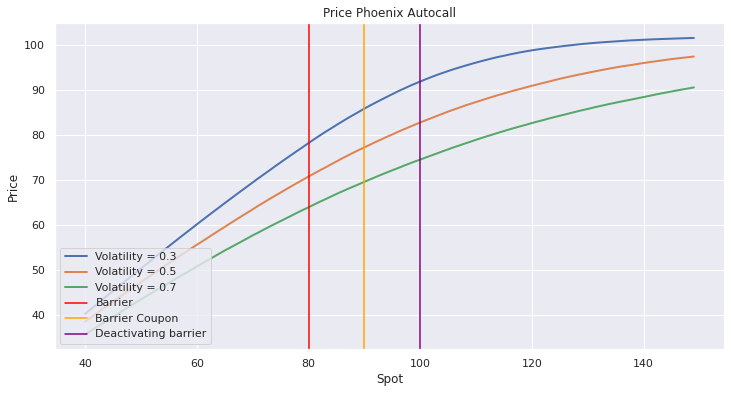

In [5]:
def plot_phoenix_prices(s):
    prices = []
    for x in range(40, 150):
          path = mc_paths(x, sigma = s)
          prices.append(np.mean(phoenix_price(path)))
    return(prices)

prices_2 = plot_phoenix_prices(0.3)
prices_3 = plot_phoenix_prices(0.5)
prices_4 = plot_phoenix_prices(0.7)

fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(range(40, 150), prices_2, linewidth=2, label = 'Volatility = 0.3')
plt.plot(range(40, 150), prices_3, linewidth=2, label = 'Volatility = 0.5')
plt.plot(range(40, 150), prices_4, linewidth=2, label = 'Volatility = 0.7')
plt.axvline(x = 80, color= "red", label = "Barrier")
plt.axvline(x = 90, color= "Orange", label = "Barrier Coupon")
plt.axvline(x = 100, color= "Purple", label = "Deactivating barrier")
plt.title('Price Phoenix Autocall')
plt.xlabel('Spot')
plt.ylabel('Price')
plt.legend(loc = 'lower left')
plt.show()

## Greeks

In [6]:
def Delta(x, sigma = 0.3):
    '''
      Compute the Delta of phoenix autocall
      Args:
          x:
            Spot Price of the Underlying
          sigma :
            Volatility
      Returns:
          The Delta of the phoenix autocall in x
      '''
    step = 0.1
    path_plus =  mc_paths(S0 = x * (1 + step),  sigma= sigma)
    path_sub =  mc_paths(S0 = x * (1 - step),  sigma= sigma)
    return( np.mean ( (phoenix_price(path_plus)-phoenix_price(path_sub)) / (2 * step * x) ) )

def Gamma(x, sigma = 0.3):
    '''
      Compute the Gamma of phoenix autocall
      Args:
          x:
            Spot Price of the Underlying
          sigma :
            Volatility
      Returns:
          The Gamma of the phoenix autocall in x
      '''
    step = 0.5
    path = mc_paths(S0 = x, sigma = sigma)
    path_plus =  mc_paths(S0 = x * (1 + step), sigma = sigma)
    path_sub =  mc_paths(S0 = x * (1 - step),  sigma = sigma)
    return ( np.mean ( (phoenix_price(path_plus)-2*phoenix_price(path)+phoenix_price(path_sub))/( (step*x)**2) ) )

def Vega(x, sigma=0.3):
    '''
      Compute the Vega of phoenix autocall
      Args:
          x:
            Spot Price of the Underlying
          sigma :
            Volatility
      Returns:
          The Vega of the phoenix autocall in x
      '''
    step = 0.5
    path_plus =  mc_paths(S0 = x, sigma = sigma*(1+step))
    path_sub =  mc_paths(S0 = x, sigma = sigma*(1-step))               
    return ( np.mean ( (phoenix_price(path_plus)-phoenix_price(path_sub)) / (2*step*sigma) ) )

def Rho(x,  sigma=0.3):
    '''
      Compute the Rho of phoenix autocall
      Args:
          x:
            Spot Price of the Underlying
          sigma :
            Volatility
      Returns:
          The Rho of the phoenix autocall in x
      '''
    step = 0.5 
    r = 0.01
    path_plus = mc_paths(S0 = x, r = r * (1+step), sigma = sigma)
    path_sub =  mc_paths(S0 = x, r = r * (1-step), sigma = sigma)
    return ( np.mean ( (phoenix_price(path_plus, r = r * (1+step)) - phoenix_price(path_sub, r = r * (1-step)) ) / (2 * step * r) )   )

def Volga(x,  sigma=0.3):
    '''
      Compute the Volga of phoenix autocall
      Args:
          x:
            Spot Price of the Underlying
          sigma :
            Volatility
      Returns:
          The Volga of the phoenix autocall in x
      '''
    step = 0.5 

    path = mc_paths(S0 = x, sigma = sigma)
    path_plus =  mc_paths(S0 = x, sigma = sigma * (1 + step))
    path_sub =  mc_paths(S0 = x, sigma = sigma * (1 - step))
    return( np.mean(phoenix_price(path_plus)-2*phoenix_price(path)+phoenix_price(path_sub))/( (step*sigma)**2) )

def Vanna(x,  sigma=0.3):
    '''
      Compute the Vanna of phoenix autocall
      Args:
          x:
            Spot Price of the Underlying
          sigma :
            Volatility
      Returns:
          The Vanna of the phoenix autocall in x
      '''
    step = 0.2

    x_plus = x * (1 + step)
    x_sub = x * (1 - step)
    sigma_plus = sigma * (1 + step)
    sigma_sub = sigma * (1 - step)

    path_plus =  mc_paths(S0 = x_plus, sigma = sigma_plus)
    path_sub_plus = mc_paths(S0 = x_sub, sigma = sigma_plus)
    path_plus_sub = mc_paths(S0 = x_plus, sigma = sigma_sub)
    path_sub =  mc_paths(S0 = x_sub, sigma = sigma_sub)
   
    return( np.mean ( (phoenix_price(path_plus) - phoenix_price(path_sub_plus) - phoenix_price(path_plus_sub) + phoenix_price(path_sub) ) / ( x * sigma * (2* step)**2  ) ) )

In [7]:
def compute_greeks(sigma):
    '''
      Compute the greeks 
      Args:
          sigma :
            Volatility
      Returns:
          delta, gamma, vega, rho, volga, vanna : 
            lists with all the greeks for a range of spot
    '''
    delta = []
    gamma = []
    vega = []
    rho = []
    volga = []
    vanna = []
    for x in range(40, 150):
        delta.append(Delta(x,  sigma = sigma))
        gamma.append(Gamma(x, sigma = sigma))
        vega.append(Vega(x,  sigma = sigma))
        rho.append(Rho(x,  sigma = sigma))
        volga.append(Volga(x,  sigma = sigma))
        vanna.append(Vanna(x,  sigma = sigma))

    return(delta, gamma, vega, rho, volga, vanna)

print('--------------------Please wait for 8min--------------------')
delta_2, gamma_2, vega_2, rho_2, volga_2, vanna_2 = compute_greeks(0.3)
delta_3, gamma_3, vega_3, rho_3, volga_3, vanna_3 = compute_greeks(0.5)
delta_4, gamma_4, vega_4, rho_4, volga_4, vanna_4 = compute_greeks(0.7)

--------------------Please wait for 8min--------------------


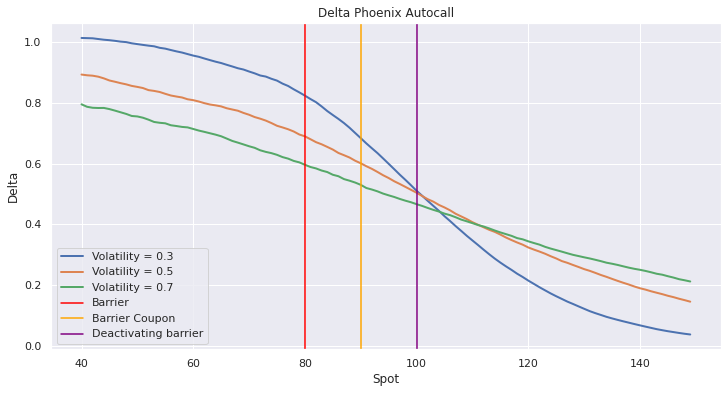

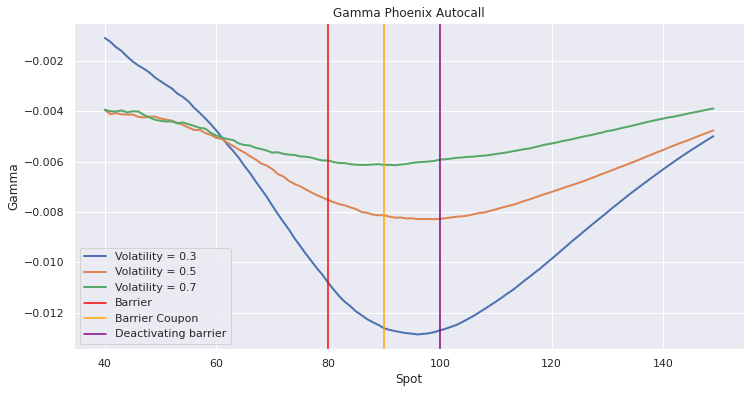

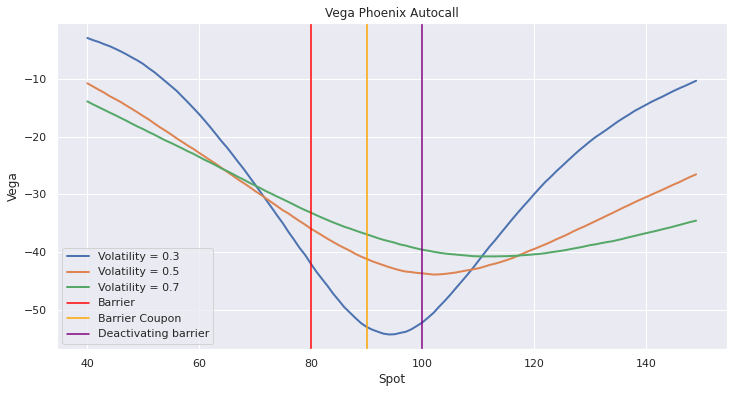

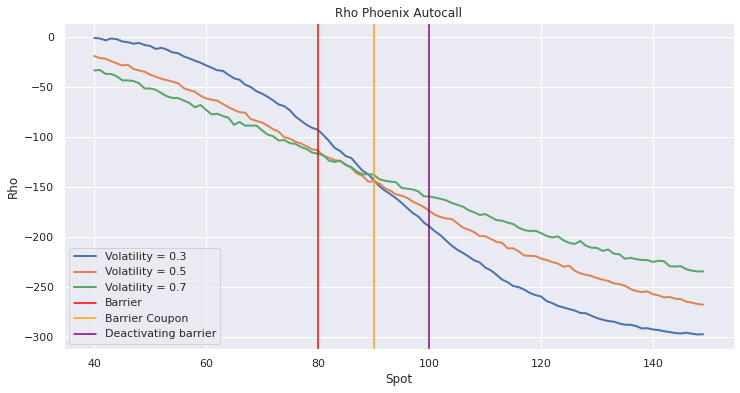

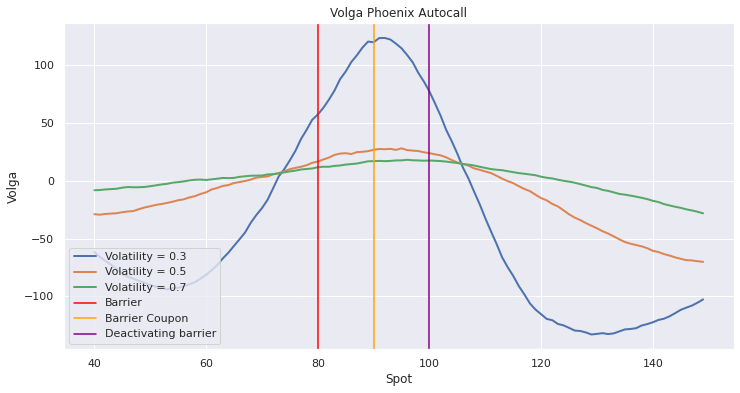

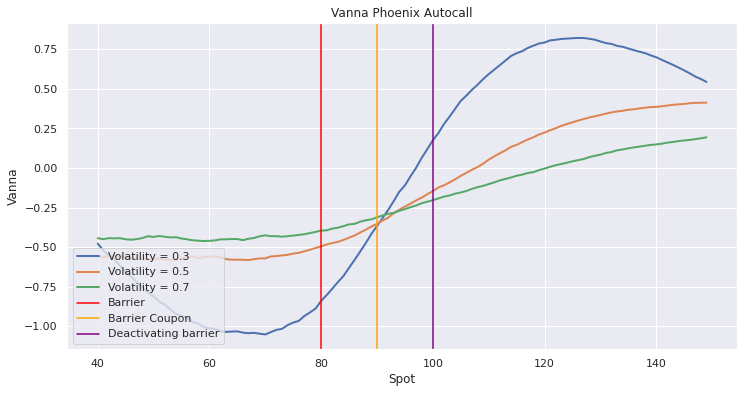

In [8]:
fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(range(40, 150), delta_2, linewidth=2, label = 'Volatility = 0.3')
plt.plot(range(40, 150), delta_3, linewidth=2, label = 'Volatility = 0.5')
plt.plot(range(40, 150), delta_4, linewidth=2, label = 'Volatility = 0.7')

plt.axvline(x = 80, color= "red", label = "Barrier")
plt.axvline(x = 90, color= "Orange", label = "Barrier Coupon")
plt.axvline(x = 100, color= "Purple", label = "Deactivating barrier")
plt.title('Delta Phoenix Autocall')
plt.xlabel('Spot')
plt.ylabel('Delta')
plt.legend(loc = 'lower left')
plt.show()

fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(range(40, 150), gamma_2, linewidth=2, label = 'Volatility = 0.3')
plt.plot(range(40, 150), gamma_3, linewidth=2, label = 'Volatility = 0.5')
plt.plot(range(40, 150), gamma_4, linewidth=2, label = 'Volatility = 0.7')
plt.axvline(x = 80, color= "red", label = "Barrier")
plt.axvline(x = 90, color= "Orange", label = "Barrier Coupon")
plt.axvline(x = 100, color= "Purple", label = "Deactivating barrier")
plt.title('Gamma Phoenix Autocall')
plt.xlabel('Spot')
plt.ylabel('Gamma')
plt.legend(loc = 'lower left')
plt.show()

fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(range(40, 150), vega_2, linewidth=2, label = 'Volatility = 0.3')
plt.plot(range(40, 150), vega_3, linewidth=2, label = 'Volatility = 0.5')
plt.plot(range(40, 150), vega_4, linewidth=2, label = 'Volatility = 0.7')
plt.axvline(x = 80, color= "red", label = "Barrier")
plt.axvline(x = 90, color= "Orange", label = "Barrier Coupon")
plt.axvline(x = 100, color= "Purple", label = "Deactivating barrier")
plt.title('Vega Phoenix Autocall')
plt.xlabel('Spot')
plt.ylabel('Vega')
plt.legend(loc = 'lower left')
plt.show()

fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(range(40, 150), rho_2, linewidth=2, label = 'Volatility = 0.3')
plt.plot(range(40, 150), rho_3, linewidth=2, label = 'Volatility = 0.5')
plt.plot(range(40, 150), rho_4, linewidth=2, label = 'Volatility = 0.7')
plt.axvline(x = 80, color= "red", label = "Barrier")
plt.axvline(x = 90, color= "Orange", label = "Barrier Coupon")
plt.axvline(x = 100, color= "Purple", label = "Deactivating barrier")
plt.title('Rho Phoenix Autocall')
plt.xlabel('Spot')
plt.ylabel('Rho')
plt.legend(loc = 'lower left')
plt.show()

fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(range(40, 150), volga_2, linewidth=2, label = 'Volatility = 0.3')
plt.plot(range(40, 150), volga_3, linewidth=2, label = 'Volatility = 0.5')
plt.plot(range(40, 150), volga_4, linewidth=2, label = 'Volatility = 0.7')
plt.axvline(x = 80, color= "red", label = "Barrier")
plt.axvline(x = 90, color= "Orange", label = "Barrier Coupon")
plt.axvline(x = 100, color= "Purple", label = "Deactivating barrier")
plt.title('Volga Phoenix Autocall')
plt.xlabel('Spot')
plt.ylabel('Volga')
plt.legend(loc = 'lower left')
plt.show()

fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(range(40, 150), vanna_2, linewidth=2, label = 'Volatility = 0.3')
plt.plot(range(40, 150), vanna_3, linewidth=2, label = 'Volatility = 0.5')
plt.plot(range(40, 150), vanna_4, linewidth=2, label = 'Volatility = 0.7')
plt.axvline(x = 80, color= "red", label = "Barrier")
plt.axvline(x = 90, color= "Orange", label = "Barrier Coupon")
plt.axvline(x = 100, color= "Purple", label = "Deactivating barrier")
plt.title('Vanna Phoenix Autocall')
plt.xlabel('Spot')
plt.ylabel('Vanna')
plt.legend(loc = 'lower left')
plt.show()